# zz

In [693]:
zs = 0.53

sehirler=["Adana", "Adıyaman", "Afyon", "Ağrı", "Amasya", "Ankara", "Antalya", "Artvin", "Aydın", "Balıkesir", 
          "Bilecik", "Bingöl", "Bitlis", "Bolu", "Burdur", "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", 
          "Diyarbakır", "Edirne", "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane", 
          "Hakkari", "Hatay", "Isparta", "Mersin", "İstanbul", "İzmir", "Kars", "Kastamonu", "Kayseri", "Kırklareli", 
          "Kırşehir", "Kocaeli", "Konya", "Kütahya", "Malatya", "Manisa", "Kahramanmaraş", "Mardin", "Muğla", "Muş", 
          "Nevşehir", "Niğde", "Ordu", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Tekirdağ", "Tokat", 
          "Trabzon", "Tunceli", "Şanlıurfa", "Uşak", "Van", "Yozgat", "Zonguldak", "Aksaray", "Bayburt", "Karaman", 
          "Kırıkkale", "Batman", "Şırnak", "Bartın", "Ardahan", "Iğdır", "Yalova", "Karabük", "Kilis", "Osmaniye", "Düzce"]

for i in range(len(sehirler)):
    sehirler[i] = sehirler[i].lower()
    sehirler[i] = sehirler[i].replace('i̇','i')

# Import libraries

In [694]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import mode

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### accuracy_calculate function

In [695]:
def accuracy_calculate(actual_values, predicted_values):

  comparison = abs(np.round(predicted_values) - actual_values)
  accuracy = 1- ((len(comparison[comparison>=(0+1)])) / len(actual_values))

  return accuracy

#### mean_iou_calculator function

In [696]:
def mean_iou_calculator(actual_values, predicted_values, time):
  confusion_array = confusion_matrix(actual_values, predicted_values)
  individual_ious = []
  for i in range(len(confusion_array)):
    individual_iou = confusion_array[i][i] / (sum(confusion_array[i]))
    individual_ious.append(individual_iou)
  mean_iou = sum(individual_ious)/len(individual_ious)
  results = pd.DataFrame()  
  featue_y_values = sorted(data[time].unique())
  for i in range(len(individual_ious)):
    results.insert(0, 'iou_(' + str(featue_y_values[i])  +')', [individual_ious[i]], True)
  results = results[results.columns[::-1]]
  results.insert(0, 'mean_iou', mean_iou, True)
  return results

# Start

In [697]:
data = pd.read_csv('gulle.csv', sep=';', encoding = "utf8")
data.columns = ['product', 'amount', 'company', 'town', 'type', 'order date', 'delivery date', 'time'] #Rearannge the dataframe as the old one

data2 = data.drop('delivery date', axis = 1)
data2["order day"] = ''
data2["order month"] = ''
data2["week day"] = ''


# Remove 'order date' and add 'order day', 'order month' and 'week day' features
for i in range(len(data2)):
  data2.at[i, 'order day'] = data2['order date'][i].split()[0]
  data2.at[i, 'order month'] = data2['order date'][i].split()[1]
  data2.at[i, 'week day'] = data2['order date'][i].split()[-1]
data2 = data2.drop('order date', axis = 1)
data2['week day'] = data2['week day'].str.replace('Pazartesi','pts')
data2['week day'] = data2['week day'].str.replace('Salı','sal')
data2['week day'] = data2['week day'].str.replace('Çarşamba','çrş')
data2['week day'] = data2['week day'].str.replace('Perşembe','prş')
data2['week day'] = data2['week day'].str.replace('Cumartesi','cts')
data2['week day'] = data2['week day'].str.replace('Cuma','cum')
data2['week day'] = data2['week day'].str.replace('Pazar','paz')

# data2 = data2[data2["week day"].str.contains("Pazar") == False]

# Rearranging Dataframe
data2 = data2[['product', 'company', 'amount', 'town', 'type', 'order day', 'week day', 'order month', 'time']]
data2['town'] = data2['town'].str.lower()
data2['town'] = data2['town'].str.replace('i̇','i')
data2['town'] = data2['town'].str.replace('.','missing')
data2['town'] = data2['town'].str.replace(' tekirdağ','tekirdağ')
data2['town'] = data2['town'].str.replace('küçükçekmece','istanbul')
data2['town'] = data2['town'].str.replace('çorlu','tekirdağ')
data2['town'] = data2['town'].str.replace('bandirma','balıkesir')

#data2 = data2.drop('town',axis = 1).reset_index(drop=True)
data2 = data2.drop('order day',axis = 1).reset_index(drop=True)
#data2 = data2.drop('order month',axis = 1).reset_index(drop=True)
data2 = data2.fillna("missing")
#data2 = data2[data2["town"].str.contains("missing") == False]

data_clean = data2.copy()
drop_df = data2.copy()
drop_index_list = []

data2

C:\Users\egeme\AppData\Local\Temp\ipykernel_19800\1197954160.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data2['town'] = data2['town'].str.replace('.','missing')


,product,company,amount,town,type,week day,order month,time
0,K477,T-029,1,bursa,1,pts,Temmuz,2
1,K669,T-016,1,istanbul,1,cum,Temmuz,4
2,K75,T-018,1,istanbul,1,çrş,Ağustos,1
3,K669,T-016,1,istanbul,1,pts,Ağustos,1
4,K513,T-034,1,istanbul,1,sal,Eylül,1
...,...,...,...,...,...,...,...,...
1111,K522,T-034,960,istanbul,1,sal,Eylül,1
1112,K730,T-060,960,tekirdağ,1,pts,Eylül,4
1113,K788,T-060,960,tekirdağ,1,pts,Eylül,4
1114,K1117,T-0211,960,kocaeli,1,sal,Nisan,1


In [698]:
data2[data2["product"]=="K1046"]

,product,company,amount,town,type,week day,order month,time
527,K1046,T-060,60,tekirdağ,1,pts,Temmuz,2
534,K1046,T-060,60,tekirdağ,1,pts,Ekim,1
542,K1046,T-060,60,tekirdağ,1,pts,Mart,1
543,K1046,T-0142,60,missing,1,sal,Nisan,1
704,K1046,T-060,120,tekirdağ,1,çrş,Şubat,1
724,K1046,T-060,120,tekirdağ,1,prş,Ekim,1
728,K1046,T-060,120,tekirdağ,1,cum,Ekim,3
730,K1046,T-060,120,tekirdağ,1,pts,Kasım,1
736,K1046,T-060,120,tekirdağ,1,pts,Şubat,2
746,K1046,T-060,120,tekirdağ,1,prş,Haziran,4


# Get list of abroad companies and products that are supplied from abroad

In [699]:
abr = [item for item in data2["town"].unique() if item not in sehirler]
abr_str = ""

for i in range (len(abr)):
    abr_str = abr_str + "|" + abr[i]
abr_str = abr_str[1:]

if len(abr) != 0:
    data3 = data2[data2["town"].astype('str').str.contains(abr_str) == True]
    abr_comp_list = data3["company"].unique()
    abr_prod_list = data3["product"].unique()
    print("abroad company list: ",abr_comp_list)
    print("abroad product list: ",abr_prod_list)
else:
    print("no abroad company")


abroad company list:  ['T-0142' 'MZ-401']
abroad product list:  ['K730' 'K390' 'MRL313' 'K1046' 'K143' 'K664' 'K9' 'K389' 'K256' 'K395']


# Remove insufficient data

In [700]:
def remove_insuff(df, ft):
    print("removing insufficient data for ", ft, "...")
    fst_len = len(df)
    x = df[ft].value_counts() < 10            ## belirtilen ft'ye ait 10'dan az veri varsa temizle
    df2 = x.to_frame().reset_index()
    df2.columns = [ft, 'booly']
    df2.drop(df2[df2.booly == False].index, inplace=True)
    drop_list = df2[ft].tolist()
    drop_indices=[]

    if len(drop_list) != 0:
        for i in df.index:
            for j in range(len(drop_list)):
                if (drop_list[j] == df.at[i, ft]):
                    drop_indices = drop_indices + [i]
        df.drop(drop_indices, inplace=True)
        
    else:
        drop_indices = []
                        
    lst_len = len(df)
    rem = fst_len - lst_len      # number of removed data
    per = (rem / fst_len) * 100  # percentage of removed data

    print("total number of removed data: ", rem)
    print("persentage of removed data: ", round(per, 2), "%")
    return df, drop_indices

In [701]:
data2, drop_indices = remove_insuff(data2, "company")
drop_index_list = drop_index_list + drop_indices

data2, drop_indices = remove_insuff(data2, "product")
drop_index_list = drop_index_list + drop_indices

removing insufficient data for  company ...
total number of removed data:  73
persentage of removed data:  6.54 %
removing insufficient data for  product ...
total number of removed data:  293
persentage of removed data:  28.09 %


# Clean noise

In [702]:
def clean_noise(df): 
    in_len = len(df)
    zs = 0.89
    
    n_prod = df["product"].nunique()
    prod_list = df["product"].unique()
    n_comp = df["company"].nunique()
    comp_list = df["company"].unique()
    
    print("Cleaning noise ... ")
    
    index_drop_list = []
    for prod in prod_list:

        df_max_scaled = df[df["product"] == prod].copy()

        for comp in comp_list:
            df_max_scaled2 = df_max_scaled[df_max_scaled["company"] == comp].copy()

            if len(df_max_scaled2) > 1:
                
                max_min_t = df_max_scaled2["time"].max() - df_max_scaled2["time"].min()
                max_min_a = df_max_scaled2["amount"].max() - df_max_scaled2["amount"].min()
                
                if (max_min_a != 0) and (max_min_t != 0):
                    df_max_scaled2["time"] = (df_max_scaled2["time"] - df_max_scaled2["time"].min()) / max_min_t
                    t_sc = df_max_scaled2[["time"]]
                    df_zscore_t = (t_sc - t_sc.mean())/t_sc.std()
                    dfz_t = abs(df_zscore_t) > zs

                    df_max_scaled2["amount"] = (df_max_scaled2["amount"] - df_max_scaled2["amount"].min()) / max_min_a
                    amo_sc = df_max_scaled2["amount"]
                    df_zscore_a = (amo_sc - amo_sc.mean())/amo_sc.std()
                    dfz_a = abs(df_zscore_a) > zs

                    df1 = dfz_t["time"] & dfz_a 
                    df2 = (df_zscore_t["time"] * df_zscore_a) < 0 
                    dfz = df1 & df2 

                    index_drop_list = index_drop_list + [*filter(dfz.get, dfz.index)]

    index_drop_list = sorted(list(set(index_drop_list)))
    df.drop(index_drop_list, axis=0, inplace=True)
    rem = len(index_drop_list)
    f_len = len(df)
    n_del = in_len - f_len
    per = (n_del / in_len) * 100
    
    print("deleted indices: ",index_drop_list)
    print("total number of removed data: ", n_del)
    print("persentage of removed data: ", round(per, 2), "%")
    
    return df, index_drop_list

In [703]:
def clean_noise_tt(df): 
    in_len = len(df)
    zst = 1.2
    
    n_prod = df["product"].nunique()
    prod_list = df["product"].unique()
    n_comp = df["company"].nunique()
    comp_list = df["company"].unique()
        
    print("Cleaning noise ... ")
    
    index_drop_list = []
    for prod in prod_list:

        df_max_scaled = df[df["product"] == prod].copy()

        for comp in comp_list:
            df_max_scaled2 = df_max_scaled[df_max_scaled["company"] == comp].copy()

            if len(df_max_scaled2) > 1:
                
                max_min_t = df_max_scaled2["time"].max() - df_max_scaled2["time"].min()
                
                if (max_min_t != 0):
                    df_max_scaled2["time"] = (df_max_scaled2["time"] - df_max_scaled2["time"].min()) / max_min_t
                    t_sc = df_max_scaled2[["time"]]
                    df_zscore_t = (t_sc - t_sc.mean())/t_sc.std()
                    dfz_t = abs(df_zscore_t) > zst
                    
                    index_drop_list += dfz_t[dfz_t["time"].eq(True)].index.tolist()
                    
                    #index_drop_list = index_drop_list + [*filter(dfz_t.get, dfz_t.index)]

    index_drop_list = sorted(list(set(index_drop_list)))
    df.drop(index_drop_list, axis=0, inplace=True)
    rem = len(index_drop_list)
    f_len = len(df)
    n_del = in_len - f_len
    per = (n_del / in_len) * 100
    
    print("deleted indices: ",index_drop_list)
    print("total number of removed data: ", n_del)
    print("persentage of removed data: ", round(per, 2), "%")
    
    return df, index_drop_list

In [704]:
pd.options.mode.chained_assignment = None

data2, train_drop_list = clean_noise(data2)
drop_index_list = drop_index_list + train_drop_list

Cleaning noise ... 
deleted indices:  [228, 255, 492, 494, 532, 547, 549, 564, 663, 701, 737, 744, 787, 956, 1024, 1037, 1088, 1089]
total number of removed data:  18
persentage of removed data:  2.4 %


In [705]:
data2, train_drop_list = clean_noise_tt(data2)
drop_index_list = drop_index_list + train_drop_list

Cleaning noise ... 
deleted indices:  [23, 34, 53, 91, 94, 103, 111, 114, 118, 135, 139, 185, 194, 195, 196, 197, 209, 218, 238, 247, 284, 286, 287, 292, 307, 308, 312, 316, 333, 336, 347, 394, 454, 458, 470, 540, 541, 552, 566, 628, 637, 655, 659, 675, 720, 728, 745, 746, 798, 807, 812, 839, 840, 851, 856, 871, 879, 882, 899, 914, 919, 947, 950, 975, 977, 981, 1005, 1035, 1065, 1066, 1082]
total number of removed data:  71
persentage of removed data:  9.7 %


In [706]:
def group_time(df):
    
    min_samp = len(df)*0.1 #len(df)*0.07
    t = 1
    gs = 0
    group = []
    sub_group = [t]
    #gap = df["time"].std()

    while t <= df["time"].max():
        
        
        if sum(df["time"] == t) > 0:
        
            gs += sum(df["time"] == t)

            if (len(sub_group) > 0) and ((t - min(sub_group)) <= math.ceil(math.sqrt(min(sub_group)))):
                sub_group += [t]

            else:
                if (len(sub_group) != 0):
                    gs = 0
                    group += [sub_group]
                sub_group = [t]

            if (gs >= min_samp) or ((t - min(sub_group)) > math.ceil(math.sqrt(min(sub_group)))):
                gs = 0
                group += [sub_group]
                sub_group = []
                
        if t == df["time"].max() :
            group += [sub_group]
            group[0].remove(1)
            
            c = True               # son sub_grouptan bir önceki sub_groupa time aktarımı
            gap = group[-2][0]     # son sub_grouptan bir önceki sub_groupa yollanan time değerleri arasındaki maksimum fark 
            while c:
                if len(group[- 1]) >= 2:
                    x = group[-1][0]
                    x_l = group[-2] [-1]
                    x_r = group[-1] [1]

                    if (x - group[-2][0]) <= math.ceil(math.sqrt(group[-2][0])):
                        group[-2].append(x)
                        group[-1].remove(x)
                
                x = group[-1][0]
                if (x - group[-2][0]) <= math.ceil(math.sqrt(group[-2][0])):
                    group[-2].append(x)
                    group[-1].remove(x)
                    
                else:
                    c = False
            
            c = True     # son sub_groupta bulunan zamanlar dataframede 5 kereden az bulunuyorsa bu sub_groupu sil
            insuff_time = []
            while c:
                s = 0
                for i in range(len(group[-1])):
                    s += sum(df["time"] == group[-1][i])
                if s < 5:
                    insuff_time += group.pop(-1)
                else:
                    c = False

        t += 1
        
    return group, insuff_time


############# son sub_groupta kalan datalara bak

In [707]:
data2.groupby('time').size()

time
1     395
2     106
3      79
4      42
5      15
6      12
7       3
9       3
10      2
11      1
14      1
34      1
44      1
dtype: int64

In [708]:
groups, insuff_time = group_time(data2)

In [709]:
insuff_time

[44, 34, 11, 14]

In [710]:
groups

[[1], [2], [3], [4, 5, 6], [7, 9, 10]]

# Map time

In [711]:
def map_time(df, groups, insuff_time):
    
    index_drop_list = []
    for i in df.index:
        for t in insuff_time:
            if df.at[i, "time"] == t:
                index_drop_list += [i]
                
    df.drop(index_drop_list, axis=0, inplace=True)

    time = 0
    for sub_group in groups:
        time += 1
        for t in sub_group:
            for i in df.index:
                if df.at[i, "time"] == t:
                    df.at[i, "time"] = time
    return df

In [712]:
map_time(data2, groups, insuff_time)

,product,company,amount,town,type,week day,order month,time
5,K669,T-0211,1,kocaeli,1,cum,Eylül,3
6,K669,T-0211,1,kocaeli,1,pts,Eylül,3
7,K669,T-0211,1,kocaeli,1,pts,Eylül,1
8,K669,T-0211,1,kocaeli,1,prş,Eylül,1
11,K407,T-0133,1,istanbul,1,pts,Eylül,1
...,...,...,...,...,...,...,...,...
1110,K730,T-0142,960,missing,1,prş,Mayıs,1
1111,K522,T-034,960,istanbul,1,sal,Eylül,1
1112,K730,T-060,960,tekirdağ,1,pts,Eylül,4
1113,K788,T-060,960,tekirdağ,1,pts,Eylül,4


In [713]:
data2["time"].unique()

array([3, 1, 4, 2, 5], dtype=int64)

# One - Hot - Encoding

In [714]:
def one_hot(df, ft):      ### ft = "company", "product", "week day" etc.
    print("one hot encoding ", ft, "...")
    dum = pd.get_dummies(df[ft])
    df = df.drop(ft, axis = 1)
    df = df.join(dum)
    print(ft, "encoded.")
    return df

In [715]:
data2  = one_hot(data2, "week day")
data2  = one_hot(data2, "company")
data2  = one_hot(data2, "product")
data2  = one_hot(data2, "order month")
data2

one hot encoding  week day ...
week day encoded.
one hot encoding  company ...
company encoded.
one hot encoding  product ...
product encoded.
one hot encoding  order month ...
order month encoded.


,amount,town,type,time,cts,cum,prş,pts,sal,çrş,...,Ekim,Eylül,Haziran,Kasım,Mart,Mayıs,Nisan,Ocak,Temmuz,Şubat
5,1,kocaeli,1,3,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,1,kocaeli,1,3,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
7,1,kocaeli,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
8,1,kocaeli,1,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11,1,istanbul,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,960,missing,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1111,960,istanbul,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1112,960,tekirdağ,1,4,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1113,960,tekirdağ,1,4,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [716]:
#data2.drop(train_drop_list, axis=0, inplace=True)
#data2.drop(val_drop_list, axis=0, inplace=True)

# Drop_df

In [717]:
drop_index_list = sorted(list(set(drop_index_list)))
drop_df = drop_df.loc[drop_index_list]
drop_df

,product,company,amount,town,type,week day,order month,time
0,K477,T-029,1,bursa,1,pts,Temmuz,2
1,K669,T-016,1,istanbul,1,cum,Temmuz,4
2,K75,T-018,1,istanbul,1,çrş,Ağustos,1
3,K669,T-016,1,istanbul,1,pts,Ağustos,1
4,K513,T-034,1,istanbul,1,sal,Eylül,1
...,...,...,...,...,...,...,...,...
1089,K9,T-060,600,tekirdağ,1,sal,Aralık,1
1090,K1061,T-0136,640,istanbul,1,cum,Nisan,5
1105,K452,T-029,950,bursa,1,prş,Temmuz,1
1106,K452,T-029,950,bursa,1,çrş,Aralık,2


In [718]:
data_clean.drop(drop_df.index.to_list(), axis=0, inplace=True)
data_clean

,product,company,amount,town,type,week day,order month,time
5,K669,T-0211,1,kocaeli,1,cum,Eylül,3
6,K669,T-0211,1,kocaeli,1,pts,Eylül,3
7,K669,T-0211,1,kocaeli,1,pts,Eylül,1
8,K669,T-0211,1,kocaeli,1,prş,Eylül,1
11,K407,T-0133,1,istanbul,1,pts,Eylül,1
...,...,...,...,...,...,...,...,...
1110,K730,T-0142,960,missing,1,prş,Mayıs,1
1111,K522,T-034,960,istanbul,1,sal,Eylül,1
1112,K730,T-060,960,tekirdağ,1,pts,Eylül,4
1113,K788,T-060,960,tekirdağ,1,pts,Eylül,4


# Drop town column

In [719]:
data2 = data2.drop('town',axis = 1).reset_index(drop=True)

# SMOTE

# Train - Test Split

In [720]:
from sklearn.model_selection import train_test_split

X = data2.copy()
Y = data2.copy()
X.drop("time", axis=1, inplace=True)
Y = Y["time"]

x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [721]:
def categorize(df):
    ls = df.columns.to_list()
    ls.remove("amount")
    df[ls] = df[ls].astype('category')
#     df['time'] = df['time'].cat.rename_categories({1:"1 gün", 2:"2 gün", 3:"3-4 gün", 4:"5-7 gün", 5:"8-14 gün", 6:"15-30 gün", 7:"+30 gün"})
    return df

In [722]:
x_train = categorize(x_train)
x_val = categorize(x_val)

# Normalize amount

In [723]:
xt_min = x_train["amount"].min()
xt_max = x_train["amount"].max()

x_train["amount"] = (x_train["amount"] - xt_min) / (xt_max - xt_min)
x_val["amount"] = (x_val["amount"] - xt_min) / (xt_max - xt_min)

# Create a df_empty with the same columns of x_train 

In [724]:
df_empty = x_train[0:0]
df_empty

,amount,type,cts,cum,prş,pts,sal,çrş,T-0127,T-0133,...,Ekim,Eylül,Haziran,Kasım,Mart,Mayıs,Nisan,Ocak,Temmuz,Şubat


# PCA

In [725]:
def do_pca(x_train, x_val):
    from sklearn.decomposition import PCA
    xl = len(x_train.columns)
    pca = PCA(.95)
    pca.fit(x_train)
    print("number of features dropped from ", xl, " to ", pca.n_components_) 
    #print("variance ratio: ", pca.explained_variance_ratio_) 

    x_train = pca.transform(x_train)
    x_val = pca.transform(x_val)
    return pca, x_train, x_val

In [726]:
pca, x_train, x_val = do_pca(x_train, x_val)

number of features dropped from  61  to  36


# SMOTE

#### SMOTENC
##### before pca for sure (there are categorical fts)

In [685]:
def get_categorical_fts(df):
    fts = list(df.columns)
    fts.remove('amount')
    return fts

In [686]:
# from imblearn.over_sampling import SMOTENC
# from collections import Counter

# print(f'Original dataset shape {x_train.shape}')
# print(f'Original dataset samples per class {Counter(y_train)}')

# # categorical features
# fts = list(range(1, ((x_train.shape[1]))))

# sm = SMOTENC(random_state=42, categorical_features=fts, sampling_strategy='all', k_neighbors=4, n_jobs=-1)
# X_res, y_res = sm.fit_resample(x_train, y_train)
# print(f'Resampled dataset samples per class {Counter(y_res)}')
# print(f'Resampled dataset shape {X_res.shape}')
# x_train, y_train = X_res, y_res

#### SMOTEENN
##### after pca?

In [687]:
# from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import SMOTE 
# from imblearn.under_sampling import EditedNearestNeighbours 
# from collections import Counter
# print('Original dataset shape %s' % Counter(y_train))
# print(f'Original dataset samples per class {Counter(y_train)}')

# sm_obj = SMOTE(random_state=42, sampling_strategy='all', k_neighbors=4, n_jobs=-1)
# enn_obj = EditedNearestNeighbours(sampling_strategy='all', n_neighbors=3, kind_sel='mode', n_jobs=-1)
# sme = SMOTEENN(random_state=42, smote=sm_obj, enn=enn_obj, sampling_strategy='all', n_jobs=-1)
# X_res, y_res = sme.fit_resample(x_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_res))
# print(f'Resampled dataset shape {X_res.shape}')
# x_train, y_train = X_res, y_res

In [688]:
params = {'max_depth': 7.778449929951673,
 'min_samples_leaf': 3.343093555340267,
 'min_samples_split': 4.450238161602154,
 'n_estimators': 267.8280516713154}

params["min_samples_leaf"] = round(params["min_samples_leaf"])
params["min_samples_split"] = round(params["min_samples_split"])
params["n_estimators"] = round(params["n_estimators"])

In [689]:
rndmForest = RandomForestClassifier(random_state=42).fit(x_train, y_train)
rndmForest_opt = RandomForestClassifier(random_state=42, **params).fit(x_train, y_train)

In [690]:
rndmForest_predictions = rndmForest.predict(x_val)
rndmForest_opt_predictions = rndmForest_opt.predict(x_val)

print('Accuracy of RandomForest classifier: ', accuracy_score(y_val, rndmForest_predictions))
print('Accuracy of RandomForest_opt classifier: ', accuracy_score(y_val, rndmForest_opt_predictions))

Accuracy of RandomForest classifier:  0.6767676767676768
Accuracy of RandomForest_opt classifier:  0.6767676767676768


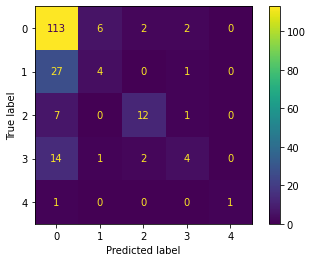

In [691]:
cm = confusion_matrix(y_val, rndmForest_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

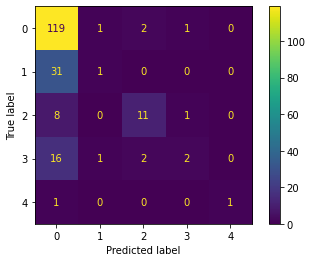

In [692]:
cm = confusion_matrix(y_val, rndmForest_opt_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Results

### Train

In [ ]:
random_state = 42
kernel = 1.0 * RBF(1.0)

Logistic_Regression = LogisticRegression(random_state= random_state, multi_class='multinomial', max_iter = 1000).fit(x_train, y_train.astype('int'))
#linearReg = LinearRegression().fit(x_train, y_train.astype('int'))
rndmForest = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=-1, min_samples_leaf=3, max_depth=5,
                                    random_state=random_state).fit(x_train, y_train.astype('int'))
                                                                   
#MLP = MLPClassifier(random_state=1, max_iter=5000).fit(x_train, y_train.astype('int'))

#Finding k value fom max accuracy
k_values=[]
for k in range(1, 51):
    KNeighbors = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(x_train, y_train.astype('int'))
    KNeighbors_predictions = KNeighbors.predict(x_val)
    k_values.append(balanced_accuracy_score(y_val, KNeighbors_predictions))
k_max = k_values.index(max(k_values)) + 1

KNeighbors = KNeighborsClassifier(n_neighbors=k_max).fit(x_train, y_train.astype('int'))
CSupportVector = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(x_train, y_train.astype('int'))
DecisionTtree = DecisionTreeClassifier(random_state=0).fit(x_train, y_train.astype('int'))
# GaussianProcess = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(x_train, y_train.astype('int'))
# AdaBoost = AdaBoostClassifier(n_estimators=1000, random_state=0).fit(x_train, y_train.astype('int'))
# GaussianNaiveBayes = GaussianNB().fit(x_train, y_train.astype('int'))
# QuadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis().fit(x_train, y_train.astype('int'))


LogisticRegression_predictions = Logistic_Regression.predict(x_train)
#linearReg_predictions = linearReg.predict(x_val)
rndmForest_predictions = rndmForest.predict(x_train)
#MLP_predictions = MLP.predict(x_val)
KNeighbors_predictions = KNeighbors.predict(x_train)
CSupportVector_predictions = CSupportVector.predict(x_train)
DecisionTtree_predictions = DecisionTtree.predict(x_train)
# GaussianProcess_predictions = GaussianProcess.predict(x_val)
# AdaBoost_predictions = AdaBoost.predict(x_val)
# GaussianNaiveBayes_predictions = GaussianNaiveBayes.predict(x_val)
# QuadraticDiscriminantAnalysis_predictions = QuadraticDiscriminantAnalysis.predict(x_val)


print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_train, LogisticRegression_predictions))
#print('Accuracy of LinearRegression classifier: ', accuracy_calculate(y_val, linearReg_predictions))
print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_train, rndmForest_predictions))
#print('Accuracy of Multi-layer Perceptron classifier: ', accuracy_calculate(y_val, MLP_predictions))
print('Accuracy of KNeighbors classifier: ', accuracy_calculate(y_train, KNeighbors_predictions))
print('Accuracy of CSupportVector classifier: ', accuracy_calculate(y_train, CSupportVector_predictions))
print('Accuracy of DecisionTtree classifier: ', accuracy_calculate(y_train, DecisionTtree_predictions))
#print('Accuracy of GaussianProcess classifier: ', accuracy_calculate(y_val, GaussianProcess_predictions))
#print('Accuracy of AdaBoost classifier: ', accuracy_calculate(y_val, AdaBoost_predictions))
#print('Accuracy of GaussianNaiveBayes classifier: ', accuracy_calculate(y_val, GaussianNaiveBayes_predictions))
#print('Accuracy of QuadraticDiscriminantAnalysis classifier: ', accuracy_calculate(y_val, QuadraticDiscriminantAnalysis_predictions))

#### Balanced Accuracy / train

In [ ]:
print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_train, LogisticRegression_predictions))
print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_train, rndmForest_predictions))
print('Balanced_Accuracy of KNeighbors classifier: ', balanced_accuracy_score(y_train, KNeighbors_predictions))
print('Balanced_Accuracy of CSupportVector classifier: ', balanced_accuracy_score(y_train, CSupportVector_predictions))
print('Balanced_Accuracy of DecisionTtree classifier: ', balanced_accuracy_score(y_train, DecisionTtree_predictions))

In [ ]:
### DENİYOZ İŞTE #################################################################

In [ ]:
# DecisionTtree = DecisionTreeClassifier(random_state=0, criterion='gini', min_samples_leaf=3, max_depth=20).fit(x_train, y_train.astype('int'))
# DecisionTtree_predictions = DecisionTtree.predict(x_train)
# print('Accuracy of DecisionTtree_predictions : ', accuracy_calculate(y_train, DecisionTtree_predictions))
# print('Balanced_Accuracy of DecisionTtree_predictions : ', balanced_accuracy_score(y_train, DecisionTtree_predictions))

# DecisionTtree_predictions = DecisionTtree.predict(x_val)
# print('Accuracy of DecisionTtree_predictions : ', accuracy_calculate(y_val, DecisionTtree_predictions))
# print('Balanced_Accuracy of DecisionTtree_predictions : ', balanced_accuracy_score(y_val, DecisionTtree_predictions))



In [ ]:
# Logistic_Regression = LogisticRegression(class_weight="balanced", multi_class="ovr", random_state= random_state, max_iter = 1000).fit(x_train, y_train.astype('int'))
# LogisticRegression_predictions = Logistic_Regression.predict(x_train)
# print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_train, LogisticRegression_predictions))
# print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_train, LogisticRegression_predictions))

# LogisticRegression_predictions = Logistic_Regression.predict(x_val)
# print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_val, LogisticRegression_predictions))
# print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_val, LogisticRegression_predictions))


In [ ]:
# svm = SGDClassifier(loss='log',class_weight="balanced", max_iter=2000).fit(x_train, y_train)
# predictions = svm.predict(x_val)
# print("accuracy: ",accuracy_score(predictions, y_val))
# print("accuracy: ",balanced_accuracy_score(predictions, y_val))

In [ ]:
###############################################################

#### LogisticRegression / train

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, LogisticRegression_predictions))
print("accuracy: ",accuracy_score(y_train, LogisticRegression_predictions))
print("precision: ",precision_score(y_train, LogisticRegression_predictions,average='weighted'))
print("recall: ",recall_score(y_train, LogisticRegression_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, LogisticRegression_predictions,average='weighted'))

cm = confusion_matrix(y_train, LogisticRegression_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_train, LogisticRegression_predictions, "time")

#### RandomForestClassifier / train

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, rndmForest_predictions))
print("accuracy: ",accuracy_score(y_train, rndmForest_predictions))
print("precision: ",precision_score(y_train, rndmForest_predictions,average='weighted'))
print("recall: ",recall_score(y_train, rndmForest_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, rndmForest_predictions,average='weighted'))

cm = confusion_matrix(y_train, rndmForest_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_train, rndmForest_predictions, "time")

#### KNeighborsClassifier  / train

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, KNeighbors_predictions))
print("accuracy: ",accuracy_score(y_train, KNeighbors_predictions))
print("precision: ",precision_score(y_train, KNeighbors_predictions,average='weighted'))
print("recall: ",recall_score(y_train, KNeighbors_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, KNeighbors_predictions,average='weighted'))

cm = confusion_matrix(y_train, KNeighbors_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_train, rndmForest_predictions, "time")

#### CSupportVector  / train

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_train, CSupportVector_predictions))
print("accuracy: ",accuracy_score(y_train, CSupportVector_predictions))
print("precision: ",precision_score(y_train, CSupportVector_predictions,average='weighted'))
print("recall: ",recall_score(y_train, CSupportVector_predictions,average='weighted'))
print("f1 score: ",f1_score(y_train, CSupportVector_predictions,average='weighted'))

cm = confusion_matrix(y_train, CSupportVector_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_train, CSupportVector_predictions, "time")

## Test

In [ ]:
# # random_state = 42
# # kernel = 1.0 * RBF(1.0)

# # Logistic_Regression = LogisticRegression(random_state= random_state, max_iter = 1000).fit(x_train, y_train.astype('int'))
# # #linearReg = LinearRegression().fit(x_train, y_train.astype('int'))
# # rndmForest = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=-1, min_samples_leaf=3, max_depth=5,
# #                                     random_state=random_state).fit(x_train, y_train.astype('int'))
                                                                   
# # #MLP = MLPClassifier(random_state=1, max_iter=5000).fit(x_train, y_train.astype('int'))

# # #Finding k value fom max accuracy
# # k_values=[]
# # for k in range(1, 51):
# #     KNeighbors = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train.astype('int'))
# #     KNeighbors_predictions = KNeighbors.predict(x_val)
# #     k_values.append(accuracy_calculate(y_val, KNeighbors_predictions))

# # k_max = k_values.index(max(k_values)) + 1
# KNeighbors = KNeighborsClassifier(n_neighbors=k_max).fit(x_train, y_train.astype('int'))
# CSupportVector = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(x_train, y_train.astype('int'))
# DecisionTtree = DecisionTreeClassifier(random_state=0).fit(x_train, y_train.astype('int'))
# # GaussianProcess = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(x_train, y_train.astype('int'))
# # AdaBoost = AdaBoostClassifier(n_estimators=1000, random_state=0).fit(x_train, y_train.astype('int'))
# # GaussianNaiveBayes = GaussianNB().fit(x_train, y_train.astype('int'))
# # QuadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis().fit(x_train, y_train.astype('int'))


LogisticRegression_predictions = Logistic_Regression.predict(x_val)
#linearReg_predictions = linearReg.predict(x_val)
rndmForest_predictions = rndmForest.predict(x_val)
#MLP_predictions = MLP.predict(x_val)
KNeighbors_predictions = KNeighbors.predict(x_val)
CSupportVector_predictions = CSupportVector.predict(x_val)
DecisionTtree_predictions = DecisionTtree.predict(x_val)
# GaussianProcess_predictions = GaussianProcess.predict(x_val)
# AdaBoost_predictions = AdaBoost.predict(x_val)
# GaussianNaiveBayes_predictions = GaussianNaiveBayes.predict(x_val)
# QuadraticDiscriminantAnalysis_predictions = QuadraticDiscriminantAnalysis.predict(x_val)


print('Accuracy of LogisticRegression classifier: ', accuracy_calculate(y_val, LogisticRegression_predictions))
#print('Accuracy of LinearRegression classifier: ', accuracy_calculate(y_val, linearReg_predictions))
print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_val, rndmForest_predictions))
#print('Accuracy of Multi-layer Perceptron classifier: ', accuracy_calculate(y_val, MLP_predictions))
print('Accuracy of KNeighbors classifier: ', accuracy_calculate(y_val, KNeighbors_predictions))
print('Accuracy of CSupportVector classifier: ', accuracy_calculate(y_val, CSupportVector_predictions))
print('Accuracy of DecisionTtree classifier: ', accuracy_calculate(y_val, DecisionTtree_predictions))
#print('Accuracy of GaussianProcess classifier: ', accuracy_calculate(y_val, GaussianProcess_predictions))
#print('Accuracy of AdaBoost classifier: ', accuracy_calculate(y_val, AdaBoost_predictions))
#print('Accuracy of GaussianNaiveBayes classifier: ', accuracy_calculate(y_val, GaussianNaiveBayes_predictions))
#print('Accuracy of QuadraticDiscriminantAnalysis classifier: ', accuracy_calculate(y_val, QuadraticDiscriminantAnalysis_predictions))

In [ ]:
# rndmForest = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=-1, min_samples_leaf=3, max_depth=5,
#                                     random_state=random_state).fit(x_train, y_train.astype('int'))
# rndmForest_predictions = rndmForest.predict(x_val)
# print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_val, rndmForest_predictions))
# print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_val, rndmForest_predictions))
# rndmForest_predictions = rndmForest.predict(x_train)
# print('Accuracy of RandomForest classifier: ', accuracy_calculate(y_train, rndmForest_predictions))
# print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_train, rndmForest_predictions))

#### Balanced Accuracy / test

In [ ]:
print('Balanced_Accuracy of LogisticRegression classifier: ', balanced_accuracy_score(y_val, LogisticRegression_predictions))
print('Balanced_Accuracy of RandomForest classifier: ', balanced_accuracy_score(y_val, rndmForest_predictions))
print('Balanced_Accuracy of KNeighbors classifier: ', balanced_accuracy_score(y_val, KNeighbors_predictions))
print('Balanced_Accuracy of CSupportVector classifier: ', balanced_accuracy_score(y_val, CSupportVector_predictions))
print('Balanced_Accuracy of DecisionTtree classifier: ', balanced_accuracy_score(y_val, DecisionTtree_predictions))

#### LogisticRegression

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, LogisticRegression_predictions))
print("accuracy: ",accuracy_score(y_val, LogisticRegression_predictions))
print("precision: ",precision_score(y_val, LogisticRegression_predictions,average='weighted'))
print("recall: ",recall_score(y_val, LogisticRegression_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, LogisticRegression_predictions,average='weighted'))

cm = confusion_matrix(y_val, LogisticRegression_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
len(y_val)

In [ ]:
mean_iou_calculator(y_val, LogisticRegression_predictions, "time")

#### RandomForestClassifier

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, rndmForest_predictions))
print("accuracy: ",accuracy_score(y_val, rndmForest_predictions))
print("precision: ",precision_score(y_val, rndmForest_predictions,average='weighted'))
print("recall: ",recall_score(y_val, rndmForest_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, rndmForest_predictions,average='weighted'))

cm = confusion_matrix(y_val, rndmForest_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_val, rndmForest_predictions, "time")

#### KNeighborsClassifier

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, KNeighbors_predictions))
print("accuracy: ",accuracy_score(y_val, KNeighbors_predictions))
print("precision: ",precision_score(y_val, KNeighbors_predictions,average='weighted'))
print("recall: ",recall_score(y_val, KNeighbors_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, KNeighbors_predictions,average='weighted'))

cm = confusion_matrix(y_val, KNeighbors_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_val, KNeighbors_predictions, "time")

#### CSupportVector

In [ ]:
print("balanced_accuracy: ",balanced_accuracy_score(y_val, CSupportVector_predictions))
print("accuracy: ",accuracy_score(y_val, CSupportVector_predictions))
print("precision: ",precision_score(y_val, CSupportVector_predictions,average='weighted'))
print("recall: ",recall_score(y_val, CSupportVector_predictions,average='weighted'))
print("f1 score: ",f1_score(y_val, CSupportVector_predictions,average='weighted'))

cm = confusion_matrix(y_val, CSupportVector_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
mean_iou_calculator(y_val, CSupportVector_predictions, "time")

# Take input and create df_inp 

In [ ]:
def is_prod_in_data(df):
    prods = df["product"].unique()
    prd = str(input("Product seç: "))
    if prd not in prods: 
        return False, prd
    else:
        return True, prd
    
def is_prod_in_data_drop(df, prd):
    prods = df["product"].unique()
    if prd not in prods: 
        return False
    else:
        return True

In [ ]:
def take_input(df, prd):
    amo = input("Amount: ") 
    y = False
    while y == False:
        if (amo.isnumeric() == False):
            print("Pozitif tam sayı değer giriniz")
            amo = input("Amount: ")

        else:
            d = max(df[df["product"] == prd]["amount"].to_list()) * 3
            if int(amo) > d:
                print("Amount yüksek abi emin misin bak !?")
                y_n = input("y / n ?")
                if y_n == "y":
                    y = True
                elif y_n == "n":
                    amo = input("Amount: ")                   
            else:
                y = True
    amo = int(amo)

    w_days = ['pts', 'sal', 'çrş', 'prş', 'cum', 'cts', 'paz']
    wd = str(input("Week day: "))
    z = False
    while z == False:
        if wd not in w_days:
            print("Geçerli gün giriniz...")
            print("Geçerli günler: ", w_days)
            wd = str(input("Week day: "))
        else:
            z = True

    typ = df[df["product"] == prd]["type"].unique()[0] 
    comps = df[df["product"] == prd]["company"].unique()
    tws = df[df["product"] == prd]["town"].unique()

    df_inp = pd.DataFrame(columns = ['product', 'company', 'amount', 'town', 'type', 'week day'])

    for comp in comps:
        tw = df[(df["product"] == prd) & (df["company"] == comp)]["town"].unique()[0]

        df_inp = df_inp.append({'product' : prd, 'company' : comp, 'amount' : amo, 'town' : tw,'type' : typ,
                            'week day' : wd}, ignore_index=True)

    return df_inp, comps

# Take Input !!!!!!!!!!!!
##### yetersiz datalardaysa ve farklı şirketlerden tedarik edilmişse ayrı ayrı ortalama süre verilebilir

In [ ]:
def run():
    #c = True
    cond1 = False ###
    #while c:
    while cond1 == False: ###
        tf, prd = is_prod_in_data(data_clean)
        
        if tf:
            df_inp, comps = take_input(data_clean, prd)
            c = False
            cond1 = True
        else:
            if (is_prod_in_data_drop(drop_df, prd) == True):
                print("Güvenilir sonuç için product'a ait en az 5 giriş bulunmalıdır.")
                print("\n","Daha önce bu product alımları: ")
                a = drop_df[drop_df["product"] == prd]
                a = a.index.to_list()
                a = data.loc[a]
                df_inp = display(a[['company', 'amount', 'town', 'order date', 'delivery date', 'time']].style.hide(axis='index'))
                print ("Ortalama miktar = ", a["amount"].mean(), "Ortalama süre = ", a["time"].mean())
                comps = a["company"].unique()
                return df_inp, cond1, comps
    
            else:
                df_inp = print("Product bulunamadı.")
    if cond1:
        df_inp  = one_hot(df_inp, "week day")
        df_inp  = one_hot(df_inp, "product")
        df_inp  = one_hot(df_inp, "company")

        df_inp = df_inp.drop('town',axis = 1).reset_index(drop=True)

        df_inp["amount"] = (df_inp["amount"] - xt_min) / (xt_max - xt_min)

        df_inp = df_empty.append(df_inp)   # for the next version of pandas use the next line of code instead of this one. 
        #df_inp = pd.concat([df_inp, df_empty])   ------->>> for the future version of pandas
        
        df_inp = df_inp.fillna(0)
        df_inp = pca.transform(df_inp)
        
    return df_inp, cond1, comps
        

In [ ]:
df_inp, cond1, comps = run()

# Predict

In [ ]:
if cond1:
    LR = Logistic_Regression.predict(df_inp)
    RF = rndmForest.predict(df_inp)
    KN = KNeighbors.predict(df_inp)
    CSV = CSupportVector.predict(df_inp)
    print("LR: ", LR, "\nRF:", RF, "\nKN:", KN, "\nCSV:", CSV)
    
    res = np.array([])
    output = np.array([])
    for i in range(len(LR)):
        res = np.append(res, [LR[i], RF[i], KN[i], CSV[i]])
        m = mode(res)[0][0]
        output = np.append(output, m)
        res = np.array([])
    
    print("for company ", comps[i], " predicted time = ", output[i])

In [ ]:
del(df_inp)